In [73]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import string
import matplotlib as plt
#nltk.download('stopwords')
#setting display options to not show high values in scientific format (specifically for revenue)
pd.options.display.float_format = '{:.0f}'.format

In [74]:
data = pd.read_csv("TMDB_movie_dataset_v11.csv")

In [75]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934745 entries, 0 to 934744
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    934745 non-null  int64  
 1   title                 934734 non-null  object 
 2   vote_average          934745 non-null  float64
 3   vote_count            934745 non-null  int64  
 4   status                934745 non-null  object 
 5   release_date          850217 non-null  object 
 6   revenue               934745 non-null  int64  
 7   runtime               934745 non-null  int64  
 8   adult                 934745 non-null  bool   
 9   backdrop_path         275491 non-null  object 
 10  budget                934745 non-null  int64  
 11  homepage              101905 non-null  object 
 12  imdb_id               552498 non-null  object 
 13  original_language     934745 non-null  object 
 14  original_title        934734 non-null  object 
 15  

some variables have many missing values--others have no missing (budget, revenue, vote information) where I will need to check whether some of those need to be null instead (budget of $0 is unlikely, should not be used as a value). Things like tagline and homepage can be ignored, won't use those vars

In [76]:
data['revenue'].replace(0, np.nan, inplace=True)
data['budget'].replace(0, np.nan, inplace=True)
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934745 entries, 0 to 934744
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    934745 non-null  int64  
 1   title                 934734 non-null  object 
 2   vote_average          934745 non-null  float64
 3   vote_count            934745 non-null  int64  
 4   status                934745 non-null  object 
 5   release_date          850217 non-null  object 
 6   revenue               18737 non-null   float64
 7   runtime               934745 non-null  int64  
 8   adult                 934745 non-null  bool   
 9   backdrop_path         275491 non-null  object 
 10  budget                44462 non-null   float64
 11  homepage              101905 non-null  object 
 12  imdb_id               552498 non-null  object 
 13  original_language     934745 non-null  object 
 14  original_title        934734 non-null  object 
 15  

genre needs to be split into list of genre tags.

In [77]:
#data.value_counts(['genres'])
data['genres'] = data['genres'].str.replace(' ','')

In [78]:
genres = pd.DataFrame(data['genres'].str.split(',', expand=True).values)
genres['id'] = data['id']

only a few movies have more than 4 genres listed, so we will truncate the genres and only consider the first four for each film

In [79]:
genres = genres.drop(list(genres)[4:16], axis=1)
genres.columns = ['genre_1','genre_2','genre_3','genre_4','id']

In [80]:
genres.head()

,genre_1,genre_2,genre_3,genre_4,id
0,Action,ScienceFiction,Adventure,None,27205
1,Adventure,Drama,ScienceFiction,None,157336
2,Drama,Action,Crime,Thriller,155
3,Action,Adventure,Fantasy,ScienceFiction,19995
4,ScienceFiction,Action,Adventure,None,24428


In [81]:
data['genres'].head()

0            Action,ScienceFiction,Adventure
1             Adventure,Drama,ScienceFiction
2                Drama,Action,Crime,Thriller
3    Action,Adventure,Fantasy,ScienceFiction
4            ScienceFiction,Action,Adventure
Name: genres, dtype: object

In [82]:
genres.loc[5000]

genre_1         Animation
genre_2    ScienceFiction
genre_3           Fantasy
genre_4            Action
id                 831405
Name: 5000, dtype: object

In [83]:
data['genres'].iloc[5000]

'Animation,ScienceFiction,Fantasy,Action'

indices are matching, merging genres columns back into full dataset.

In [84]:
data = data.merge(genres, on='id')

In [85]:
data.iloc[325]

id                                                                 405774
title                                                            Bird Box
vote_average                                                            7
vote_count                                                           9227
status                                                           Released
release_date                                                   2018-12-13
revenue                                                               NaN
runtime                                                               124
adult                                                               False
backdrop_path                            /pDKFL1zcHzEpmz4MJA5JJnRbJeD.jpg
budget                                                           19800000
homepage                           https://www.netflix.com/title/80196789
imdb_id                                                         tt2737304
original_language                     

doing some spot checking to make sure that the merge appropriately matched the new columns with the list of genres for each film

In [86]:
for i in range(10):
    print(data[['genres','genre_1','genre_2','genre_3','genre_4']].iloc[320+i])

genres     Action,Adventure,ScienceFiction
genre_1                             Action
genre_2                          Adventure
genre_3                     ScienceFiction
genre_4                               None
Name: 320, dtype: object
genres     Horror,Drama,Thriller
genre_1                   Horror
genre_2                    Drama
genre_3                 Thriller
genre_4                     None
Name: 321, dtype: object
genres     Romance,Family,Animation,Fantasy
genre_1                             Romance
genre_2                              Family
genre_3                           Animation
genre_4                             Fantasy
Name: 322, dtype: object
genres     Mystery,Drama,Crime
genre_1                Mystery
genre_2                  Drama
genre_3                  Crime
genre_4                   None
Name: 323, dtype: object
genres     Action,Adventure,Comedy,ScienceFiction
genre_1                                    Action
genre_2                                 Adven

There are a great many listed with no revenue. Lots of reasons for this: international films, made-for-tv films, pay per view sports events, adult films, etc.
Removing: adult films, unreleased films, films with reported revenue less than $1000 (an arbitrary cutoff, but intended to remove things that made little to no money and likely were not released widely), films with less than 60 minute runtime (mostly foreign films and non-feature films anyway--not released in the traditional theatrical model in the US and unlikely to have comparable revenue)

In [87]:
data = data[(data['adult'] == False)]
data = data[(data['status'] == 'Released')]
data = data[(data['revenue'] > 1000)]
data = data[(data['runtime'] > 60)]

looking at release dates

In [88]:
data['release_date'] = pd.to_datetime(data['release_date'], format="%Y-%m-%d")
data['release_month'] = data['release_date'].dt.month

array([[<Axes: title={'center': 'release_date'}>]], dtype=object)

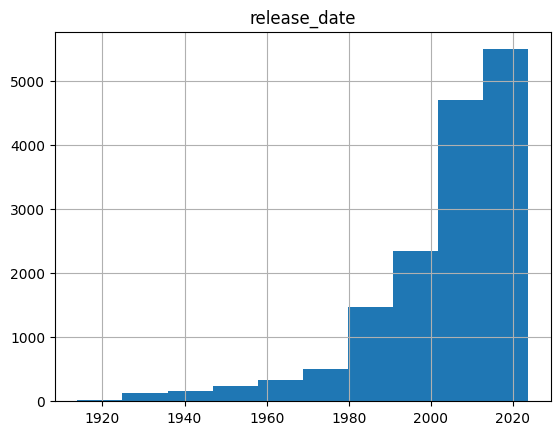

In [89]:
data.hist(["release_date"])

will remove movies with release dates in the future. will go back a few months to avoid including movies released in the past couple of months that do not have full release windows to earn their final revenue. will also remove movies prior to 1970. Rationale: fewer instances, different theatrical release strategy, 1960s-70s was when the 'blockbuster' movie started and things looked more like they do now (streaming aside). 1950s were when television started to compete with film, and so film distribution strategy started to adapt.

In [90]:
data = data[(data['release_date'] < "2023-10-01")]
data = data[(data['release_date'] > "1970-01-01")]

Revenue and budget need to be adjusted for inflation to be more comparable over time

<Axes: xlabel='release_date', ylabel='revenue'>

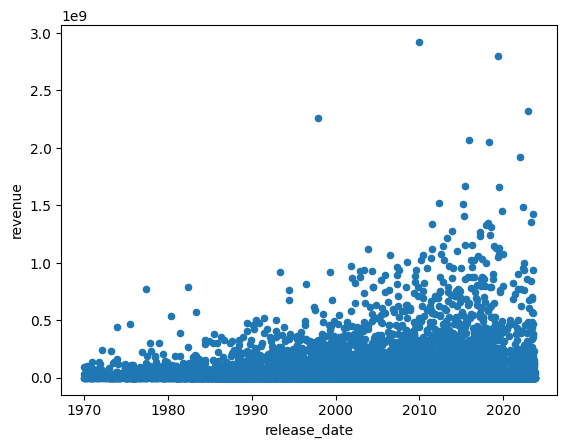

In [91]:
data.plot.scatter(x='release_date', y='revenue')

<Axes: xlabel='release_date', ylabel='budget'>

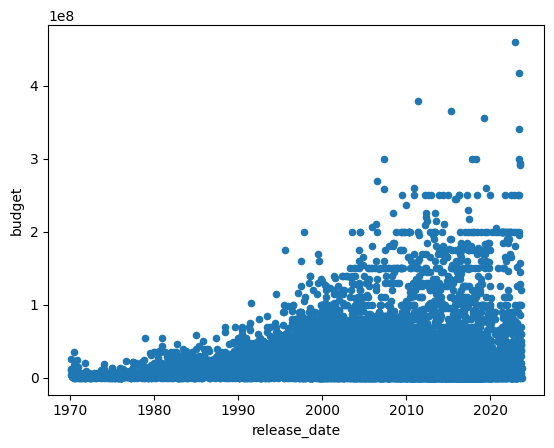

In [92]:
data.plot.scatter(x='release_date',y='budget')

inflation data retrieved from FRED (Federal Reserve Economic Data) from the St. Louis Fed (see references in proposal)

In [93]:
inflation_data = pd.read_csv('CPIAUCNS.csv')

renaming date column to match dataset for merging
converting date column to datetime format for merging
creating multiplier by indexing the inflation variable to the most recent row of inflation data.

In [94]:
inflation_data.head()
inflation_data = inflation_data.rename(columns={'DATE':'rounded_date'})
inflation_data['rounded_date'] = pd.to_datetime(inflation_data['rounded_date'], format="%Y-%m-%d")
inflation_data['inflation_multiplier'] = inflation_data['CPIAUCNS'].iloc[-1] / inflation_data['CPIAUCNS']

creating a rounded date variable set to the first of the month for merging with inflation dataset

In [95]:
from pandas.tseries.offsets import MonthBegin

data['rounded_date'] = pd.to_datetime(data['release_date']) - MonthBegin(1)

In [96]:
data = pd.merge(data, inflation_data, how='left', on='rounded_date')

In [97]:
data['adj_revenue'] = data['revenue'] * data['inflation_multiplier']
data['adj_budget'] = data['budget'] * data['inflation_multiplier']
data['profit'] = data['adj_revenue'] - data['adj_budget']

<Axes: xlabel='release_date', ylabel='adj_revenue'>

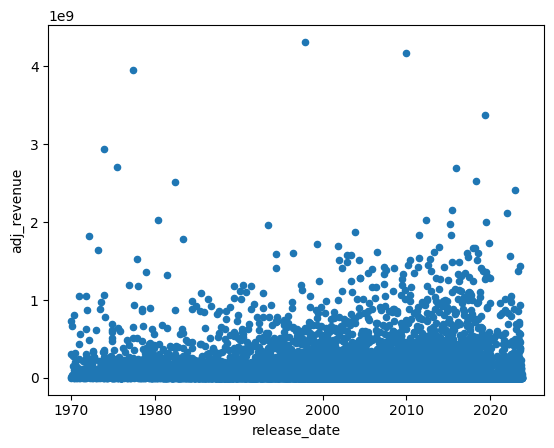

In [98]:
data.plot.scatter(x='release_date', y='adj_revenue')

<Axes: xlabel='release_date', ylabel='adj_budget'>

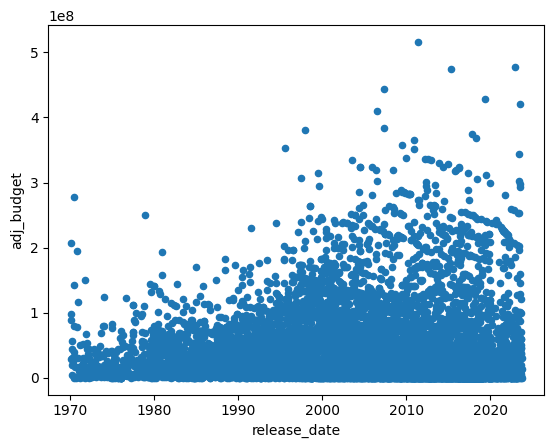

In [99]:
data.plot.scatter(x='release_date', y='adj_budget')

this has helped even out the distribution slightly. movies in recent years still make more money (and cost a lot more money) than in the 1960s-1970s, but at least it's in the same unit now.

In [100]:
data = data.drop(columns=['status','adult','homepage','tagline','CPIAUCNS','rounded_date'])

In [101]:
data['genre_1'].value_counts()

genre_1
Drama             3632
Comedy            3178
Action            1952
Horror             938
Adventure          657
Thriller           620
Crime              562
Animation          518
Romance            476
Documentary        439
Family             299
Fantasy            278
ScienceFiction     276
Mystery            169
Music              157
War                116
History             91
Western             45
TVMovie              5
Name: count, dtype: int64

removing the tv movies from analysis. there are very few of them and they don't factor into revenue the same way anyway.

In [102]:
data.loc[data['genre_1'] == 'TVMovie']

,id,title,vote_average,vote_count,release_date,revenue,runtime,backdrop_path,budget,imdb_id,...,spoken_languages,genre_1,genre_2,genre_3,genre_4,release_month,inflation_multiplier,adj_revenue,adj_budget,profit
7295,15691,Doctor Who,6,195,1996-05-12,42000000,89,/26MVKVGQf1J0yrzJx97Ww4DLslV.jpg,5000000,tt0116118,...,English,TVMovie,Adventure,ScienceFiction,None,5,2,82548774,9827235,72721539
12169,373332,Murder Town,7,11,2015-03-19,50604,91,/vrTbidKLu35LNqBeMeNgx9w5DT1.jpg,NaN,tt4419304,...,German,TVMovie,Crime,Drama,None,3,1,65964,NaN,NaN
13324,292136,Rock Sangkut,6,3,2014-07-30,100000,137,/hhwuLALcZLcRXpQABBzDXZzLST3.jpg,100000,NaN,...,Malay,TVMovie,Drama,None,None,7,1,129187,129187,0
13350,905068,Christmas with The Chosen: The Messengers,7,3,2021-12-01,13728000,110,/flL1IWMnMuush1SVYapkKvQCmCg.jpg,NaN,tt15772866,...,NaN,TVMovie,Drama,History,Music,12,1,15201863,NaN,NaN
14043,450154,Bellator 175: Rampage vs. King Mo 2,7,1,2017-03-31,1033113,144,/9dC1bou5yrfZSr6Q6k6pEk879v3.jpg,1,NaN,...,English,TVMovie,None,None,None,3,1,1304264,1,1304263


In [103]:
data = data[(data['genre_1'] != 'TVMovie')]
data = data[(data['genre_2'] != 'TVMovie')]
data = data[(data['genre_3'] != 'TVMovie')]
data = data[(data['genre_4'] != 'TVMovie')]
data = data[(data['genres'].notnull())]
data = data.reset_index(drop=True)

expanding genre columns out into binary variables

In [104]:
genre_list = data['genre_1'].value_counts().keys().tolist()
genre_keys = np.arange(0,18)
genre_dict = dict(zip(genre_list, genre_keys))

In [105]:
genre_dict

{'Drama': 0,
 'Comedy': 1,
 'Action': 2,
 'Horror': 3,
 'Adventure': 4,
 'Thriller': 5,
 'Crime': 6,
 'Animation': 7,
 'Romance': 8,
 'Documentary': 9,
 'Family': 10,
 'Fantasy': 11,
 'ScienceFiction': 12,
 'Mystery': 13,
 'Music': 14,
 'War': 15,
 'History': 16,
 'Western': 17}

In [106]:
data.shape

(14379, 28)

In [107]:
genre_matrix = np.zeros((len(data), 18))
genre_matrix.shape

(14379, 18)

this loop fills in a matrix of all the genres based on the row index and the column index from the genre dictionary.

In [108]:
for i, movie_row in data.iterrows():
    #print(movie_row[19:23])
    #this stupid check has to be in here or the indexing doesn't work. don't ask me why.
    if i > 15968:
        break
    for genre in movie_row[19:23]:
        #print(genre)
        #print(genre_matrix[i])
        if genre:
            #print(f"{i=}, {g_i=}, {genre=}")
            g_i = genre_dict[genre]
            genre_matrix[i,g_i] = genre_matrix[i,g_i]+1
            #print(genre_matrix[i])

In [109]:
genre_matrix_df = pd.DataFrame(genre_matrix, columns=genre_list)

In [110]:
genre_matrix_df

,Drama,Comedy,Action,Horror,Adventure,Thriller,Crime,Animation,Romance,Documentary,Family,Fantasy,ScienceFiction,Mystery,Music,War,History,Western
0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14374,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14375,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
14376,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
14377,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [111]:
len(data) == len(genre_matrix_df)

True

In [148]:
data_features = data.join(genre_matrix_df)

In [149]:
data_features['week_num'] = data_features['release_date'].dt.isocalendar().week

making a list of paths to the hosted poster images using documentation for the TMDB dataset https://developer.themoviedb.org/docs/image-basics

In [150]:
poster_images = data_features[['id','poster_path','genre_1','genre_2','genre_3','genre_4','release_month']]
poster_images['poster_url'] = 'https://image.tmdb.org/t/p/original' + poster_images['poster_path'].astype(str)

C:\Users\clfairbairn\AppData\Local\Temp\ipykernel_6116\2601930421.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poster_images['poster_url'] = 'https://image.tmdb.org/t/p/original' + poster_images['poster_path'].astype(str)


In [151]:
poster_images

,id,poster_path,genre_1,genre_2,genre_3,genre_4,release_month,poster_url
0,27205,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Action,ScienceFiction,Adventure,None,7,https://image.tmdb.org/t/p/original/oYuLEt3zVC...
1,157336,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Adventure,Drama,ScienceFiction,None,11,https://image.tmdb.org/t/p/original/gEU2QniE6E...
2,155,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Drama,Action,Crime,Thriller,7,https://image.tmdb.org/t/p/original/qJ2tW6WMUD...
3,19995,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Action,Adventure,Fantasy,ScienceFiction,12,https://image.tmdb.org/t/p/original/kyeqWdyUXW...
4,24428,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,ScienceFiction,Action,Adventure,None,4,https://image.tmdb.org/t/p/original/RYMX2wcKCB...
...,...,...,...,...,...,...,...,...
14374,1097990,/3p5yO67xwJHy9H6bUJS4z2Vfz8I.jpg,Comedy,Drama,None,None,6,https://image.tmdb.org/t/p/original/3p5yO67xwJ...
14375,953480,/5tfr5daRqzhzYON1SsOsiMHk3Nj.jpg,Romance,None,None,None,9,https://image.tmdb.org/t/p/original/5tfr5daRqz...
14376,721807,/66TF9r6pkXmluUmXhOHw7sCzys9.jpg,Drama,Family,None,None,11,https://image.tmdb.org/t/p/original/66TF9r6pkX...
14377,448603,/nOpSSSB7ruVoZXJ4ERvZuh91ia4.jpg,Thriller,Drama,None,None,3,https://image.tmdb.org/t/p/original/nOpSSSB7ru...


In [152]:
import pickle

with open('posters.pkl', 'wb') as f_pickle:
    pickle.dump(poster_images, f_pickle)

In [117]:
data_features = data_features.drop(
    columns=['backdrop_path', 'imdb_id', 'genres', 'production_companies', 'production_countries', 'spoken_languages',
             'revenue', 'budget', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'original_language',
             'original_title', 'inflation_multiplier', 'poster_path'])

In [118]:
data_features

,id,title,vote_average,vote_count,release_date,runtime,overview,popularity,release_month,adj_revenue,...,Documentary,Family,Fantasy,ScienceFiction,Mystery,Music,War,History,Western,week_num
0,27205,Inception,8,34495,2010-07-15,148,"Cobb, a skilled thief who commits corporate es...",84,7,1165491209,...,0,0,0,1,0,0,0,0,0,28
1,157336,Interstellar,8,32571,2014-11-05,169,The adventures of a group of explorers who mak...,140,11,914603498,...,0,0,0,1,0,0,0,0,0,45
2,155,The Dark Knight,9,30619,2008-07-16,152,Batman raises the stakes in his war on crime. ...,131,7,1405648374,...,0,0,0,0,0,0,0,0,0,29
3,19995,Avatar,8,29815,2009-12-15,162,"In the 22nd century, a paraplegic Marine is di...",80,12,4167116097,...,0,0,1,1,0,0,0,0,0,51
4,24428,The Avengers,8,29166,2012-04-25,143,When an unexpected enemy emerges and threatens...,98,4,2031747869,...,0,0,0,1,0,0,0,0,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14374,1097990,What Doesn't Float,0,0,2023-06-10,69,An anthology of New Yorkers at their wit's end.,1,6,7323,...,0,0,0,0,0,0,0,0,0,23
14375,953480,Aadhya Papam,0,0,1988-09-10,86,Adipapam (transl. Original sin) is a 1988 Indi...,1,9,841500,...,0,0,0,0,0,0,0,0,0,36
14376,721807,Care of Footpath,0,0,2006-11-24,135,An orphan slum boy who is adopted by an old la...,1,11,1481664,...,0,1,0,0,0,0,0,0,0,47
14377,448603,Dream Killer,0,0,1995-03-17,90,Police officer Cheng (Michael Wong) gets into ...,4,3,947647,...,0,0,0,0,0,0,0,0,0,11


In [119]:
data_features['adj_revenue'].corr(data_features['adj_budget'])

0.6692892328945702

In [120]:
data_features['adj_revenue'].corr(data_features['week_num'])

0.04172210742657054

In [121]:
data_features['adj_revenue'].corr(data_features['profit'])

0.9811612671731421

rounding the adj revenue variable to the nearest million to simplify things. then removing rows for films that made less than 1m dollars.

In [122]:
data_features['adj_revenue_millions'] = round(data_features['adj_revenue'],-6)/1000000

In [123]:
data_features = data_features[(data_features['adj_revenue_millions'] >= 1)]

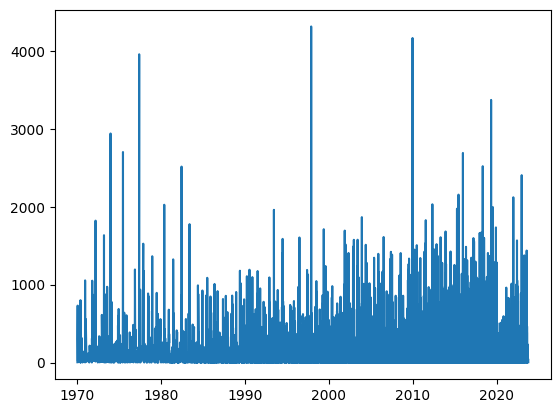

In [124]:
xs = data_features['release_date']
ys = data_features['adj_revenue_millions']

xs, ys = zip(*sorted(zip(xs, ys)))

plt.pyplot.plot(xs, ys)

there are spikes in this, hard to tell if it's cyclical or not. gonna try time series decomposition to see what happens

In [125]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = data_features[['release_date','adj_revenue_millions']]
decomp = decomp.set_index('release_date')
decomp = decomp.sort_index()
result = seasonal_decompose(decomp, model='additive', period=365)

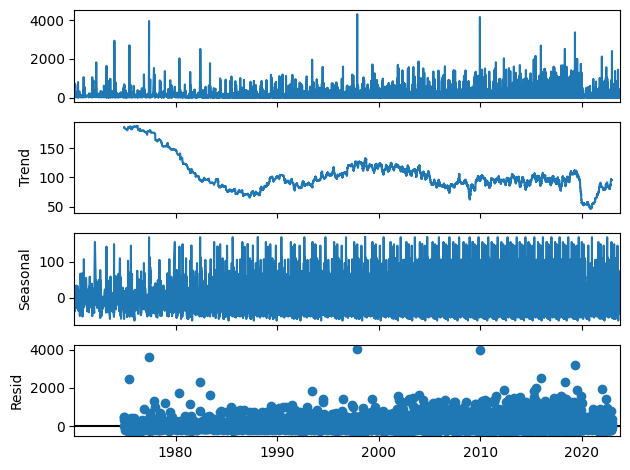

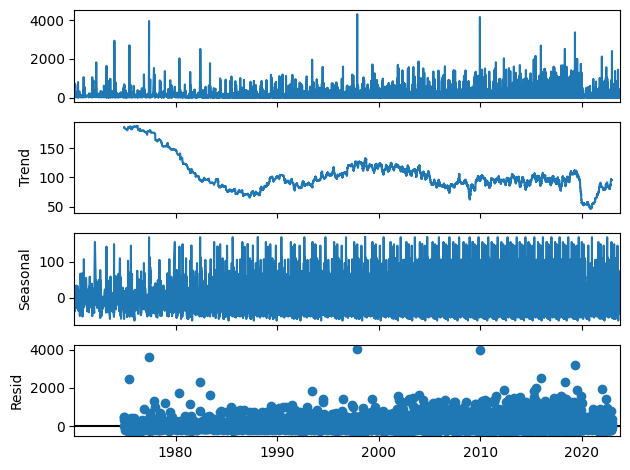

In [126]:
result.plot()

to be honest, I don't know how to interpret this! And the references I found were difficult to translate to this use case. I'm going to abandon this approach.

In [127]:
data_features

,id,title,vote_average,vote_count,release_date,runtime,overview,popularity,release_month,adj_revenue,...,Family,Fantasy,ScienceFiction,Mystery,Music,War,History,Western,week_num,adj_revenue_millions
0,27205,Inception,8,34495,2010-07-15,148,"Cobb, a skilled thief who commits corporate es...",84,7,1165491209,...,0,0,1,0,0,0,0,0,28,1165
1,157336,Interstellar,8,32571,2014-11-05,169,The adventures of a group of explorers who mak...,140,11,914603498,...,0,0,1,0,0,0,0,0,45,915
2,155,The Dark Knight,9,30619,2008-07-16,152,Batman raises the stakes in his war on crime. ...,131,7,1405648374,...,0,0,0,0,0,0,0,0,29,1406
3,19995,Avatar,8,29815,2009-12-15,162,"In the 22nd century, a paraplegic Marine is di...",80,12,4167116097,...,0,1,1,0,0,0,0,0,51,4167
4,24428,The Avengers,8,29166,2012-04-25,143,When an unexpected enemy emerges and threatens...,98,4,2031747869,...,0,0,1,0,0,0,0,0,17,2032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14364,1079863,Maamu Tension Nai Leneka,0,0,2007-10-12,105,"""MAAMU TENSION NAI LENEKA"" A HINDI FEATURE FIL...",1,10,4419377,...,0,0,0,0,0,0,0,0,41,4
14369,1105011,Double face,0,0,1977-03-26,87,"Drugs, money, murder, prison... Burdened by si...",1,3,1034585,...,0,0,0,0,0,0,0,0,12,1
14375,953480,Aadhya Papam,0,0,1988-09-10,86,Adipapam (transl. Original sin) is a 1988 Indi...,1,9,841500,...,0,0,0,0,0,0,0,0,36,1
14376,721807,Care of Footpath,0,0,2006-11-24,135,An orphan slum boy who is adopted by an old la...,1,11,1481664,...,1,0,0,0,0,0,0,0,47,1


trying out light natural language processing on the 'overview' column to find common keywords in the plot. followed example from here: https://www.dataquest.io/blog/how-to-clean-and-prepare-your-data-for-analysis/

since I don't really know how to use the natural language information in machine learning applications, I'm going to create a very crude indicator of popular themes by counting the number of words in the cleaned overview field that are included in the list of the most commonly used words.

In [128]:
data_features['stripped_overview'] = data_features['overview'].str.lower()

def remove_punctuation(text):
    for char in string.punctuation:
        text = str(text)
        text = text.replace(char, ' ')
    return text

data_features['stripped_overview'] = data_features['stripped_overview'].apply(remove_punctuation)

C:\Users\clfairbairn\AppData\Local\Temp\ipykernel_6116\405615557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_features['stripped_overview'] = data_features['overview'].str.lower()
C:\Users\clfairbairn\AppData\Local\Temp\ipykernel_6116\405615557.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_features['stripped_overview'] = data_features['stripped_overview'].apply(remove_punctuation)


In [129]:
stop = stopwords.words("english")

data_features['stripped_overview'] = data_features['stripped_overview'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

C:\Users\clfairbairn\AppData\Local\Temp\ipykernel_6116\3550874519.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_features['stripped_overview'] = data_features['stripped_overview'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))


In [130]:
common_words = data_features.stripped_overview.str.split(expand=True).stack().value_counts()[0:300]
synopses = data_features['stripped_overview'].str.split(' ').tolist()
common_words = common_words.reset_index()
common_words = common_words['index'].tolist()
common_words_list = list(common_words)

In [132]:
with open('words.pkl','wb') as f_pickle:
    pickle.dump(common_words, f_pickle)

In [133]:
commonwords_column = []
counter = 0
# print(type(common_words))

for synopsis in synopses:
    synopsis = set(synopsis)
    for word in synopsis:
        if word in common_words:
            counter += 1
        else:
            pass

    commonwords_column.append(counter)
    counter = 0

In [134]:
commonwords_column

[4,
 4,
 8,
 3,
 7,
 7,
 8,
 8,
 3,
 7,
 9,
 9,
 2,
 4,
 11,
 6,
 7,
 14,
 4,
 12,
 5,
 3,
 6,
 11,
 7,
 10,
 3,
 21,
 7,
 9,
 10,
 25,
 14,
 9,
 6,
 4,
 9,
 6,
 11,
 12,
 9,
 6,
 11,
 14,
 5,
 12,
 9,
 8,
 6,
 7,
 10,
 6,
 10,
 10,
 12,
 11,
 5,
 9,
 8,
 12,
 5,
 7,
 9,
 4,
 5,
 10,
 20,
 21,
 6,
 20,
 4,
 3,
 10,
 5,
 3,
 11,
 11,
 11,
 13,
 8,
 5,
 4,
 13,
 19,
 12,
 5,
 8,
 2,
 13,
 9,
 12,
 15,
 14,
 11,
 6,
 14,
 4,
 2,
 8,
 3,
 5,
 15,
 5,
 8,
 4,
 8,
 13,
 13,
 4,
 3,
 5,
 4,
 1,
 6,
 10,
 13,
 8,
 13,
 6,
 5,
 6,
 6,
 6,
 18,
 13,
 1,
 16,
 7,
 7,
 3,
 11,
 5,
 14,
 11,
 3,
 3,
 9,
 9,
 13,
 7,
 7,
 12,
 6,
 14,
 4,
 6,
 7,
 9,
 2,
 1,
 10,
 7,
 9,
 10,
 6,
 3,
 12,
 8,
 12,
 8,
 15,
 9,
 8,
 9,
 6,
 4,
 7,
 10,
 14,
 10,
 19,
 4,
 7,
 9,
 17,
 13,
 13,
 4,
 5,
 4,
 9,
 12,
 5,
 7,
 11,
 22,
 6,
 5,
 3,
 6,
 13,
 9,
 11,
 9,
 12,
 10,
 3,
 12,
 8,
 10,
 11,
 2,
 10,
 7,
 4,
 11,
 4,
 4,
 5,
 24,
 9,
 7,
 7,
 15,
 14,
 6,
 7,
 11,
 3,
 14,
 7,
 7,
 8,
 7,
 7,
 14,
 17,
 8,
 8,


In [135]:
data_features = data_features.reset_index()

In [136]:
data_features.loc[:,'common_word_count'] = pd.Series(commonwords_column)

In [137]:
data_features

,index,id,title,vote_average,vote_count,release_date,runtime,overview,popularity,release_month,...,ScienceFiction,Mystery,Music,War,History,Western,week_num,adj_revenue_millions,stripped_overview,common_word_count
0,0,27205,Inception,8,34495,2010-07-15,148,"Cobb, a skilled thief who commits corporate es...",84,7,...,1,0,0,0,0,0,28,1165,cobb skilled thief commits corporate espionage...,4
1,1,157336,Interstellar,8,32571,2014-11-05,169,The adventures of a group of explorers who mak...,140,11,...,1,0,0,0,0,0,45,915,adventures group explorers make use newly disc...,4
2,2,155,The Dark Knight,9,30619,2008-07-16,152,Batman raises the stakes in his war on crime. ...,131,7,...,0,0,0,0,0,0,29,1406,batman raises stakes war crime help lt jim gor...,8
3,3,19995,Avatar,8,29815,2009-12-15,162,"In the 22nd century, a paraplegic Marine is di...",80,12,...,1,0,0,0,0,0,51,4167,22nd century paraplegic marine dispatched moon...,3
4,4,24428,The Avengers,8,29166,2012-04-25,143,When an unexpected enemy emerges and threatens...,98,4,...,1,0,0,0,0,0,17,2032,unexpected enemy emerges threatens global safe...,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11568,14364,1079863,Maamu Tension Nai Leneka,0,0,2007-10-12,105,"""MAAMU TENSION NAI LENEKA"" A HINDI FEATURE FIL...",1,10,...,0,0,0,0,0,0,41,4,maamu tension nai leneka hindi feature film st...,1
11569,14369,1105011,Double face,0,0,1977-03-26,87,"Drugs, money, murder, prison... Burdened by si...",1,3,...,0,0,0,0,0,0,12,1,drugs money murder prison burdened sins premat...,15
11570,14375,953480,Aadhya Papam,0,0,1988-09-10,86,Adipapam (transl. Original sin) is a 1988 Indi...,1,9,...,0,0,0,0,0,0,36,1,adipapam transl original sin 1988 indian malay...,3
11571,14376,721807,Care of Footpath,0,0,2006-11-24,135,An orphan slum boy who is adopted by an old la...,1,11,...,0,0,0,0,0,0,47,1,orphan slum boy adopted old lady finds footpat...,16


i wonder if the number of genres is too high to help with prediction. let's try consolidating some of the genres into groups
action/adventure/war/western
horror/thriller
family/animation
sciencefiction/fantasy
history/drama
comedy/romance/music
documentary
crime/mystery


In [138]:
data_features.loc[(data_features['Action'] == True) | (data_features['Adventure'] == True) | (data_features['War'] == True) | (data_features['Western'] == True), 'action_adv_war_west'] = 1
data_features.loc[(data_features['action_adv_war_west'].isna()), 'action_adv_war_west'] = 0

In [139]:
data_features.loc[(data_features['Horror'] == True) | (data_features['Thriller'] == True), 'horror_thriller'] = 1
data_features.loc[(data_features['horror_thriller'].isna()), 'horror_thriller'] = 0

In [140]:
data_features.loc[(data_features['Family'] == True)  | (data_features['Animation'] == True), 'family_animate'] = 1
data_features.loc[(data_features['family_animate'].isna()), 'family_animate'] = 0

In [141]:
data_features.loc[(data_features['ScienceFiction'] == True)  | (data_features['Fantasy'] == True), 'scifi_fantasy'] = 1
data_features.loc[(data_features['scifi_fantasy'].isna()), 'scifi_fantasy'] = 0

In [142]:
data_features.loc[(data_features['History'] == True)  | (data_features['Drama'] == True), 'hist_drama'] = 1
data_features.loc[(data_features['hist_drama'].isna()), 'hist_drama'] = 0

In [143]:
data_features.loc[(data_features['Crime'] == True)  | (data_features['Mystery'] == True), 'crime_mystery'] = 1
data_features.loc[(data_features['crime_mystery'].isna()), 'crime_mystery'] = 0

In [144]:
data_features.loc[(data_features['Comedy'] == True)  | (data_features['Romance'] == True)  | (data_features['Music'] == True), 'comedy_romance_music'] = 1
data_features.loc[(data_features['comedy_romance_music'].isna()), 'comedy_romance_music'] = 0

In [145]:
data_features

,index,id,title,vote_average,vote_count,release_date,runtime,overview,popularity,release_month,...,adj_revenue_millions,stripped_overview,common_word_count,action_adv_war_west,horror_thriller,family_animate,scifi_fantasy,hist_drama,crime_mystery,comedy_romance_music
0,0,27205,Inception,8,34495,2010-07-15,148,"Cobb, a skilled thief who commits corporate es...",84,7,...,1165,cobb skilled thief commits corporate espionage...,4,1,0,0,1,0,0,0
1,1,157336,Interstellar,8,32571,2014-11-05,169,The adventures of a group of explorers who mak...,140,11,...,915,adventures group explorers make use newly disc...,4,1,0,0,1,1,0,0
2,2,155,The Dark Knight,9,30619,2008-07-16,152,Batman raises the stakes in his war on crime. ...,131,7,...,1406,batman raises stakes war crime help lt jim gor...,8,1,1,0,0,1,1,0
3,3,19995,Avatar,8,29815,2009-12-15,162,"In the 22nd century, a paraplegic Marine is di...",80,12,...,4167,22nd century paraplegic marine dispatched moon...,3,1,0,0,1,0,0,0
4,4,24428,The Avengers,8,29166,2012-04-25,143,When an unexpected enemy emerges and threatens...,98,4,...,2032,unexpected enemy emerges threatens global safe...,7,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11568,14364,1079863,Maamu Tension Nai Leneka,0,0,2007-10-12,105,"""MAAMU TENSION NAI LENEKA"" A HINDI FEATURE FIL...",1,10,...,4,maamu tension nai leneka hindi feature film st...,1,0,0,0,0,0,0,1
11569,14369,1105011,Double face,0,0,1977-03-26,87,"Drugs, money, murder, prison... Burdened by si...",1,3,...,1,drugs money murder prison burdened sins premat...,15,0,0,0,0,1,0,0
11570,14375,953480,Aadhya Papam,0,0,1988-09-10,86,Adipapam (transl. Original sin) is a 1988 Indi...,1,9,...,1,adipapam transl original sin 1988 indian malay...,3,0,0,0,0,0,0,1
11571,14376,721807,Care of Footpath,0,0,2006-11-24,135,An orphan slum boy who is adopted by an old la...,1,11,...,1,orphan slum boy adopted old lady finds footpat...,16,0,0,1,0,1,0,0


In [146]:
data_features_clean = data_features.drop(columns=['title','vote_average','vote_count','overview','popularity','adj_budget','profit','Drama','Comedy','Action','Horror','Adventure','Thriller','Crime','Animation','Romance','Family','Fantasy','ScienceFiction','Mystery','Music','War','Western','History','stripped_overview'])

In [147]:
data_features_clean.to_csv("features.csv")